<a href="https://colab.research.google.com/github/mk7890/Industrial-Equipment-Fault-Detection-Machine-Learning-1-Capstone-Project/blob/main/ML1_Capstone_Industrial_equipment_fault_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project aims to develop a machine learning model for fault prediction in industrial equipment, leveraging a dataset that includes sensor measurements (temperature, pressure, vibration, humidity), equipment types, and locations. By addressing the limitations of traditional scheduled maintenance, the model seeks to enhance preventive maintenance strategies through accurate classification of equipment states. Using data-driven techniques, a classification approache will be explored, and model performance will be evaluated with metrics such as precision, recall, and F1-score to identify the most effective fault detection system. The ultimate goal is to optimize maintenance processes, reduce downtime, and improve industrial efficiency by demonstrating the potential of predictive analytics in enhancing the reliability of complex systems.

# IMPORTING LIBRARIES

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot
from IPython.display import IFrame

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import randint
import itertools
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    auc,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)

# LOADING THE DATASET

Downloading the Dataset from Kaggle

In [2]:
!kaggle datasets download -d dnkumars/industrial-equipment-monitoring-dataset

Dataset URL: https://www.kaggle.com/datasets/dnkumars/industrial-equipment-monitoring-dataset
License(s): apache-2.0
100% 291k/291k [00:00<00:00, 887kB/s]
100% 291k/291k [00:00<00:00, 885kB/s]


Extracting the Dataset

In [3]:
import zipfile
zipfile_path = '/content/industrial-equipment-monitoring-dataset.zip'
csv_file = zipfile_path.replace('zip', '')
with zipfile.ZipFile(zipfile_path, 'r') as file:
  file.extractall()
  print('Done')

Done


Creating a Pandas Dataframe

In [4]:
dataframe=pd.read_csv("/content/equipment_anomaly_data.csv")
dataframe.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


# EXPLORATORY DATA ANALYSIS (EDA)

In [241]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [242]:
dataframe.isnull().sum()

,0
temperature,0
pressure,0
vibration,0
humidity,0
equipment,0
location,0
faulty,0


In [243]:
dataframe.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922419,35.738015,1.611889,50.016575,0.099974
std,16.200082,10.381654,0.728573,11.841468,0.299985
min,10.270000,3.620000,-0.430000,10.220000,0.000000
25%,62.775000,29.490000,1.170000,42.615000,0.000000
50%,70.160000,35.230000,1.530000,50.025000,0.000000
75%,77.570000,41.160000,1.920000,57.340000,0.000000
max,149.690000,79.890000,4.990000,89.980000,1.000000


In [6]:
dataframe.columns

Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'location', 'faulty'],
      dtype='object')

## ploting histograms for each column to visualize distributions

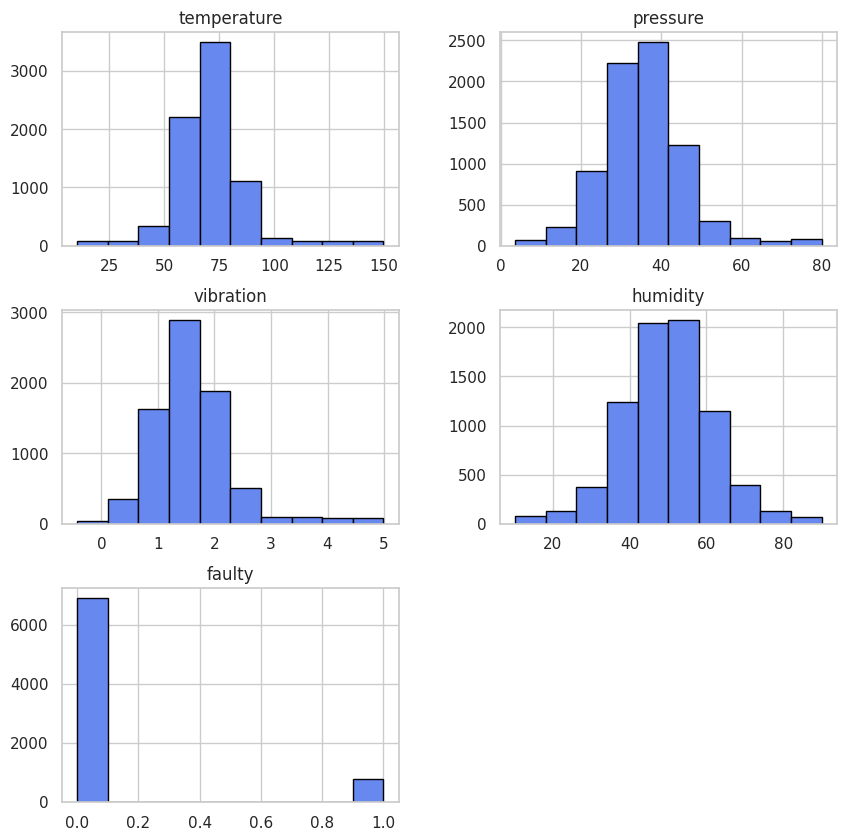

In [244]:
dataframe.hist(figsize=(10,10), edgecolor="black")
plt.show()

In [245]:
dataframe.columns


Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'location', 'faulty'],
      dtype='object')

## Pairplot for bivariate scatter plot distributions

<Figure size 6250x6250 with 0 Axes>

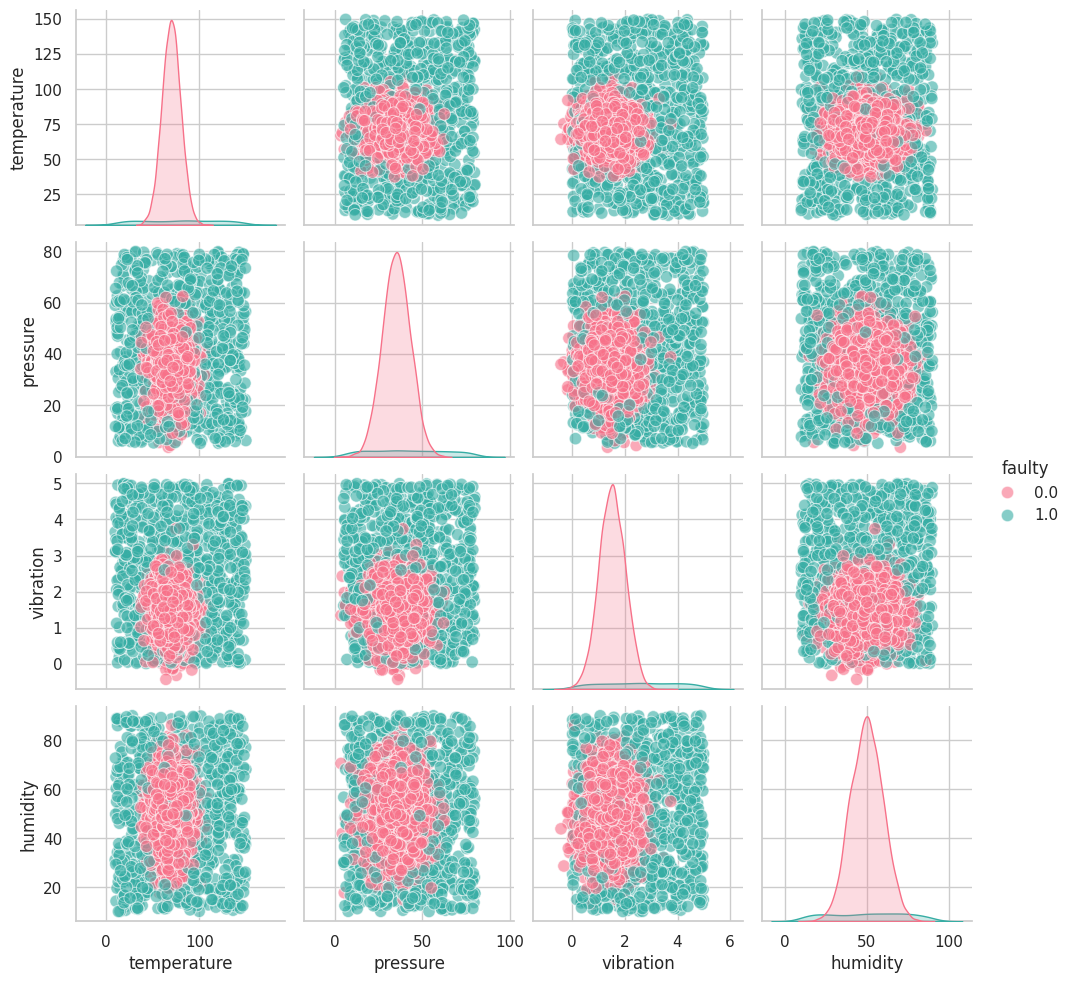

In [246]:
# observe for the float_data
plt.figure(figsize=(25, 25), dpi=250)
sns.set(style="whitegrid")  # Set the plot style
sns.set_palette("coolwarm")    # Set the color palette
sns.pairplot(dataframe.select_dtypes("number"), hue='faulty', palette='husl', plot_kws={'alpha': 0.6, 's': 80})

## Imbalanced Fault Classification Distribution

Text(0, 0.5, 'Count')

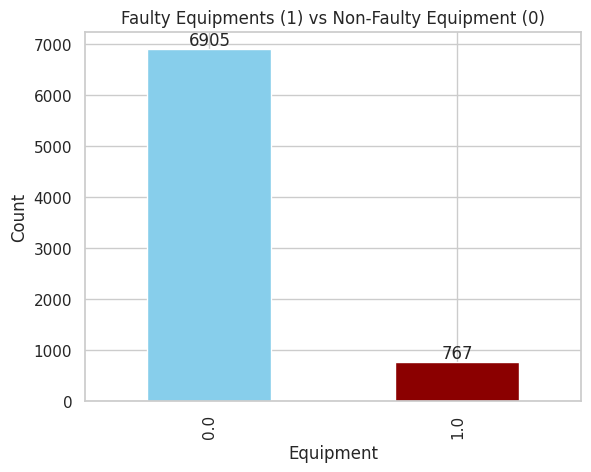

In [247]:
faulty_equipments=dataframe["faulty"].value_counts()
faulty_equipments.plot(kind="bar",color=['skyblue','darkred'])
for i,values in enumerate(faulty_equipments):
     plt.text(i,values,str(values),ha="center",va="bottom")

plt.title("Faulty Equipments (1) vs Non-Faulty Equipment (0)")
plt.xlabel("Equipment")
plt.ylabel("Count")

Insight: There's a class imbalance between faulty (767) and non-faulty (6905) equipment as observed on the bargraph. This will affect modeling in not addressed.

## Equipment Type Distribution

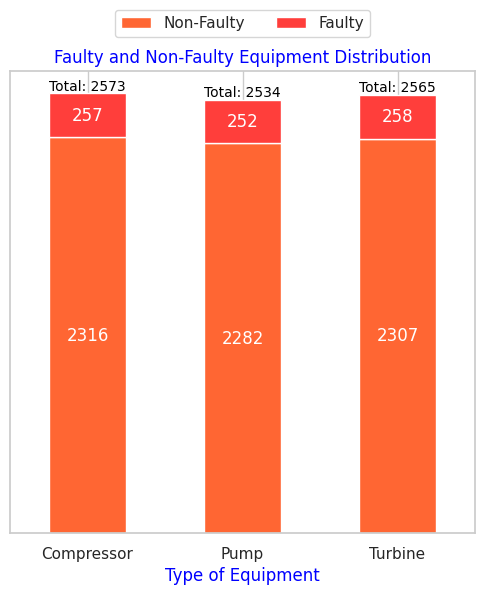

In [248]:
# Count faulty and non-faulty instances for each equipment type
faulty_counts = dataframe[dataframe['faulty'] == 1]['equipment'].value_counts()
non_faulty_counts = dataframe[dataframe['faulty'] == 0]['equipment'].value_counts()
# Align counts for plotting
all_equipment = sorted(dataframe['equipment'].unique())
faulty_counts = faulty_counts.reindex(all_equipment, fill_value=0)
non_faulty_counts = non_faulty_counts.reindex(all_equipment, fill_value=0)
equipment_counts = pd.DataFrame({'Non-Faulty': non_faulty_counts, 'Faulty': faulty_counts}) # Combine counts into a single DataFrame
colors = ['#FF6633', '#FF3E3B'] # Colors for non-faulty and faulty
ax = equipment_counts.plot(kind='bar', stacked=True, color=colors, figsize=(6, 6), legend=True) # Plot stacked bar graph
ax.yaxis.set_visible(False) # Remove the y-axis
# Add labels for counts on each bar
for i, equipment in enumerate(all_equipment):
    non_faulty = non_faulty_counts[equipment]
    faulty = faulty_counts[equipment]
    total = non_faulty + faulty
    plt.text(i, non_faulty / 2, str(non_faulty), ha="center", va="center", color="white") # Non-Faulty bar label
    plt.text(i, non_faulty + faulty / 2, str(faulty), ha="center", va="center", color="white") # Faulty bar label
    plt.text(i, total, f"Total: {total}", ha="center", va="bottom", fontsize=10, color="black") # Total label

plt.legend(['Non-Faulty', 'Faulty'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2) # Add custom legend outside the plot
# Customize plot
plt.xticks(rotation=0)
plt.xlabel("Type of Equipment", color="blue")
plt.title("Faulty and Non-Faulty Equipment Distribution", font="arial", color="blue")
plt.show()


Insight: The plot shows that the equipment distribution for Compressors, Pumps, and Turbines is fairly equal in terms of frequency counts.

## Total Equipment Distribution by Location

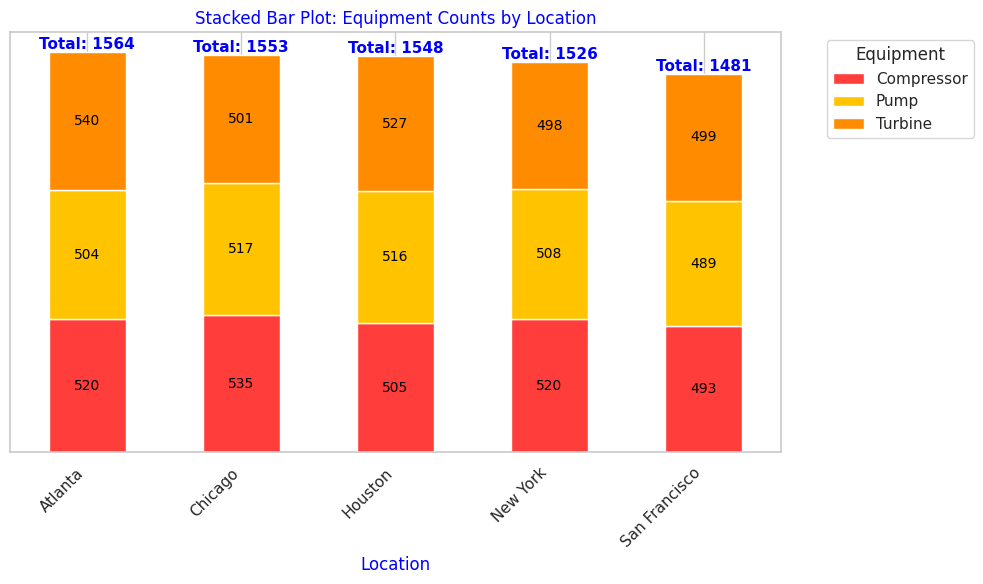

In [249]:
grouped_data = dataframe.groupby(['location', 'equipment']).size().reset_index(name='count') # Group by location and equipment, then count occurrences
pivot_data = grouped_data.pivot(index='location', columns='equipment', values='count').fillna(0) # Pivot the data for stacked bar plotting
custom_colors = ['#FF3E3B', '#FFC300', '#FF8C00']  # Custom colors for equipment types : Red, Yellow, Orange
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors, legend=True) # Plot stacked bar graph
ax.yaxis.set_visible(False) # Remove the y-axis
# Annotate counts on the stacked bars
for i, location in enumerate(pivot_data.index):
    y_offset = 0  # Tracks the cumulative height for stacking
    for equipment, value in pivot_data.loc[location].items():
        if value > 0:  # Only annotate non-zero values
            ax.text(x=i, y=y_offset + value / 2, s=int(value), ha='center', va='center', color='black', fontsize=10)
            y_offset += value
    # Annotate the total count for the bar
    total = pivot_data.loc[location].sum()
    ax.text(x=i, y=y_offset, s=f"Total: {int(total)}", ha='center', va='bottom', color='blue', fontsize=11, fontweight='bold')
# Customize the plot
plt.xticks(rotation=45, ha='right')  # Rotate location names for better visibility
plt.xlabel("Location", color="blue")
plt.ylabel("Count", color="blue")
plt.title("Stacked Bar Plot: Equipment Counts by Location", color="blue")
plt.legend(title="Equipment", bbox_to_anchor=(1.05, 1), loc='upper left') # Move the legend outside the plot
plt.tight_layout() # Adjust layout
plt.show()


Insight: Equipment counts for all five locations are fairly evenly distributed, with only minimal variations observed.

## Outliers Visualization

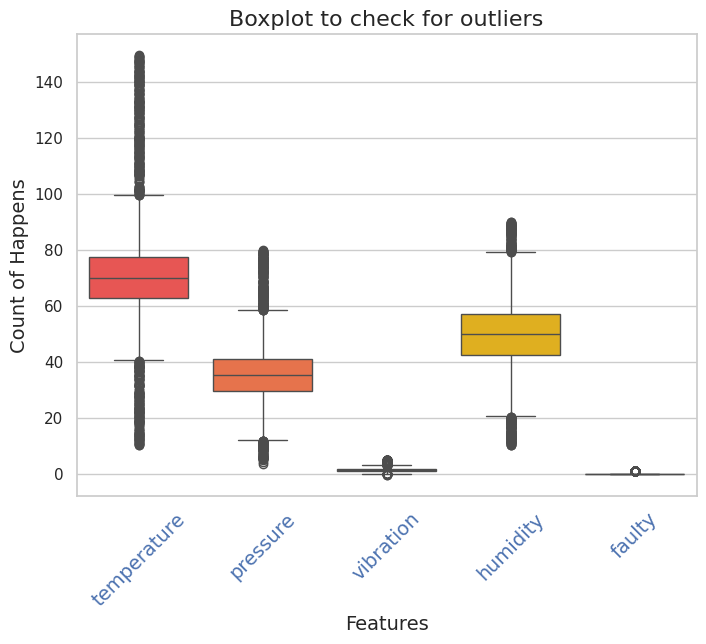

In [250]:
colors = ['#FF3E3B', '#FF6633', '#FF9C19', '#FFBF00', '#FFFF00'] # Color palette
# Plot
plt.figure(figsize=(8, 6))
plt.title("Boxplot to check for outliers", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Count of Happens", fontsize=14)
plt.xticks(rotation=45, color="b", fontsize=14)
sns.boxplot(data=dataframe, palette=colors)  # Apply the palette
plt.show()

Insight: Temperature, pressure and humidity columns contain quite the outliers, this is important to note when doing feature scaling.

## Pairplot for Bivarite Comparisons with trendline

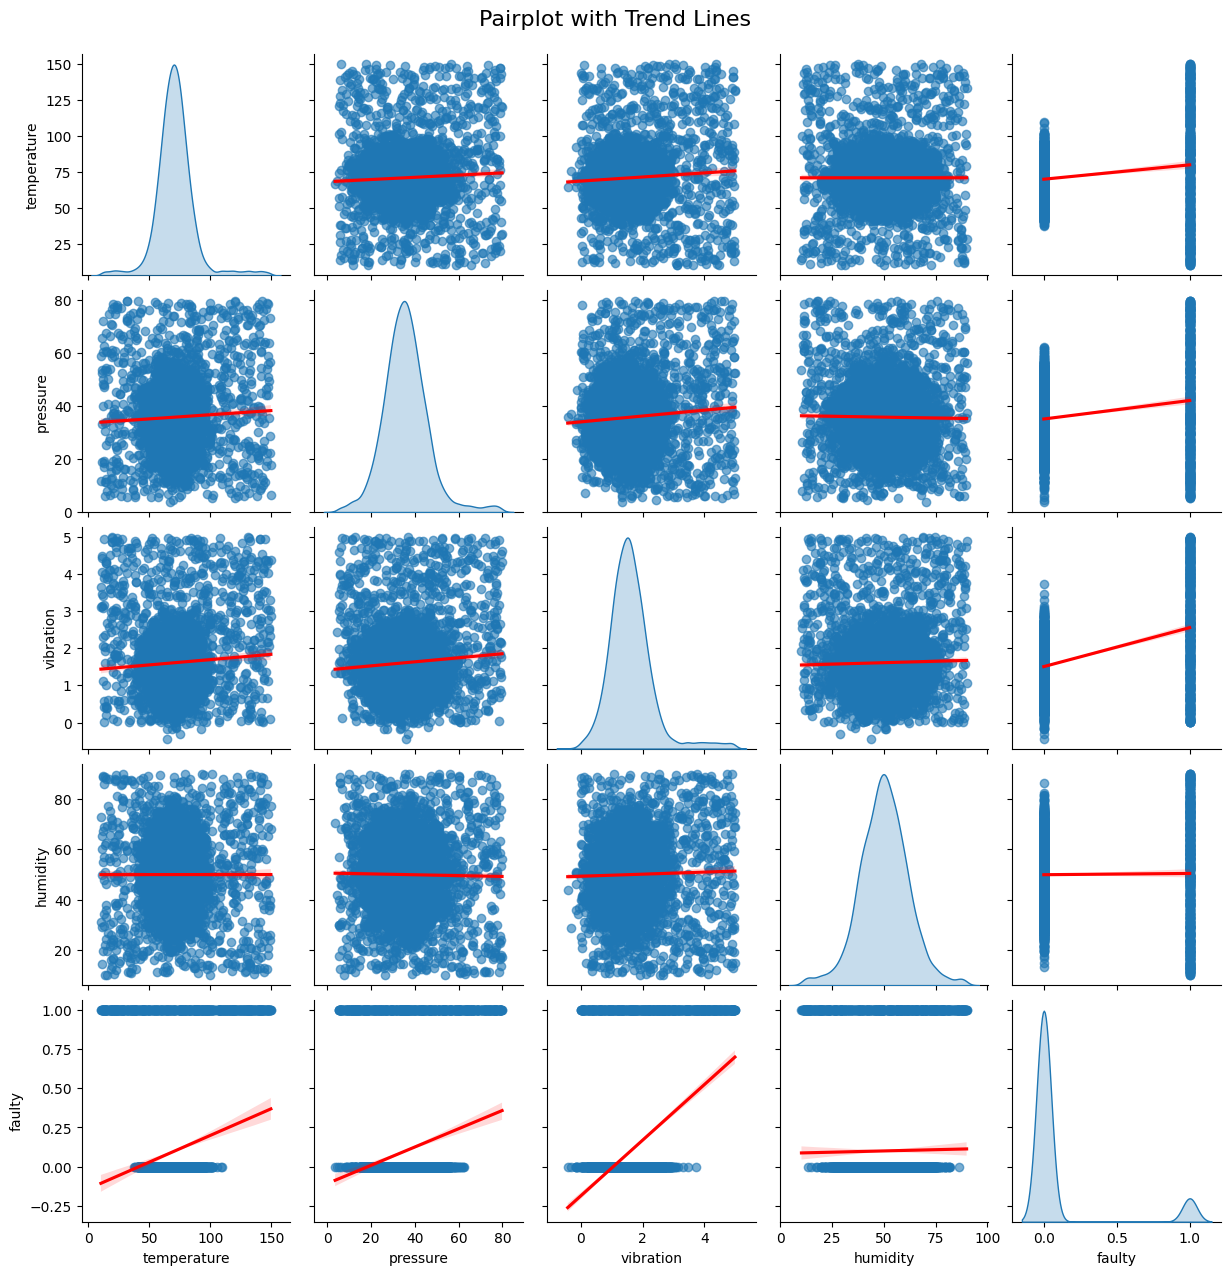

In [8]:
# Pairplot with regression trend lines
sns.pairplot(dataframe, kind='reg', diag_kind='kde',
             plot_kws={'scatter_kws': {'alpha': 0.6}, 'line_kws': {'color': 'red'}})
plt.suptitle('Pairplot with Trend Lines', y=1.02, fontsize=16)
plt.show()

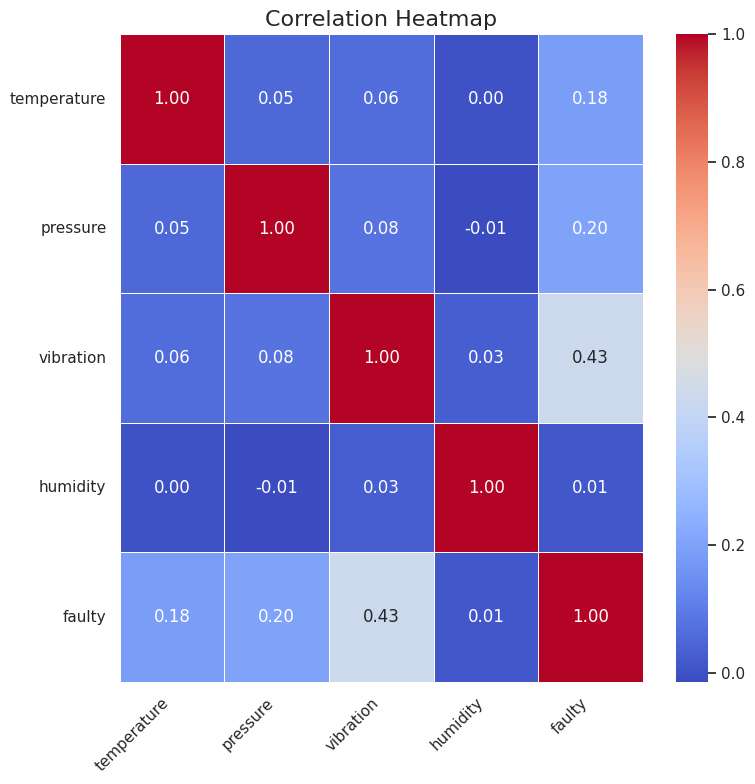

In [251]:
numeric_data = dataframe.select_dtypes(include=['number']) # Select only numeric columns
correlation_matrix = numeric_data.corr() # Calculate the correlation matrix for numerical columns
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True) # Create a heatmap using seaborn
# Customize plot
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
# Show the plot
plt.tight_layout()
plt.show()


Insight: There's notable correlation between vibration and faulty columns, as well as pressure and faulty columns. This means that pressure and vibrations contribute more to equipment fault development.

# DATA PREPROCESSING

## Encoding

One-hot encoding will be used to encode the 'equipment' and 'location' columns because it's fast and the columns don't contain high cardinality data

In [252]:
# one hot encoding equipment and location columns
dataframe=pd.get_dummies(dataframe,columns=["equipment","location"])
# convert boolean columns to ones and zeroes
dataframe = dataframe.replace({True: 1, False: 0})
dataframe.head()

<ipython-input-252-632b1ffa18b3>:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,temperature,pressure,vibration,humidity,faulty,equipment_Compressor,equipment_Pump,equipment_Turbine,location_Atlanta,location_Chicago,location_Houston,location_New York,location_San Francisco
0,58.18,25.03,0.61,45.69,0.0,0,0,1,1,0,0,0,0
1,75.74,22.95,2.34,41.87,0.0,1,0,0,0,1,0,0,0
2,71.36,27.28,1.39,58.95,0.0,0,0,1,0,0,0,0,1
3,71.62,32.24,1.77,40.57,0.0,0,1,0,1,0,0,0,0
4,66.51,45.20,0.35,43.25,0.0,0,1,0,0,0,0,1,0


In [253]:
dataframe.columns

Index(['temperature', 'pressure', 'vibration', 'humidity', 'faulty',
       'equipment_Compressor', 'equipment_Pump', 'equipment_Turbine',
       'location_Atlanta', 'location_Chicago', 'location_Houston',
       'location_New York', 'location_San Francisco'],
      dtype='object')

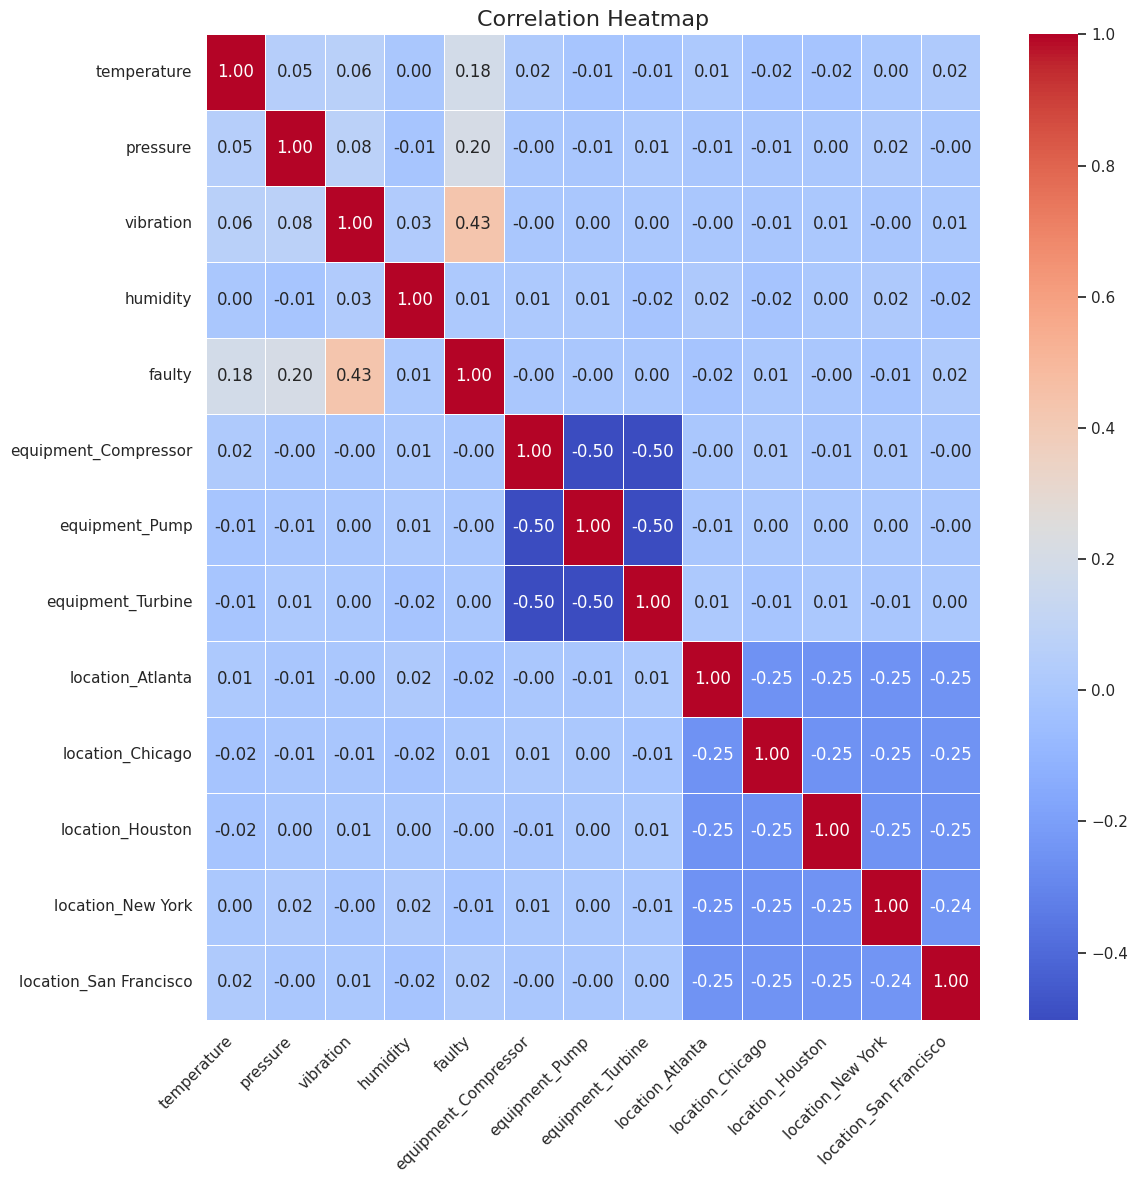

In [254]:
numeric_data = dataframe.select_dtypes(include=['number']) # Select only numeric columns
correlation_matrix = numeric_data.corr() # Calculate the correlation matrix for numerical columns
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True) # Create a heatmap using seaborn
# Customize plot
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
# Show the plot
plt.tight_layout()
plt.show()

## Train-Test Split

A 60-20-20 dataset split was used to divide the dataset into three parts:

- Training set (60%) - Used to train the model.
- Validation set (20%) - Used to tune the model's hyperparameters and evaluate its performance during training.
- Test set (20%) - Used to evaluate the final model's performance on unseen data.

This split ensures that the model is tested on completely unseen data after being optimized on the validation set, providing an unbiased estimate of its performance.

In [255]:
# dropping the target column in the dataset.
X = dataframe.drop('faulty', axis=1)
y = dataframe['faulty']

# Splitting the data into training (60%), validation (20%), and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Applying SMOTE (Synthetic Minority Oversappling Technique) on the Training data only

In [256]:
# Applying SMOTE only to the training set
smote = SMOTE(random_state=42)

Robust scaling
- This method is used to handle outliers better than standardization or normalization. It's based on percentiles, like the median and the interquartile range (IQR).

Mean normalization
- This technique is used when the data has a known range but varies around the mean. It centers the data around the mean and scales it between -1 and 1.


In [257]:
# Columns for scaling
robust_cols = ["humidity", "temperature", "pressure"]
minmax_cols = ["vibration"]

# Column transformer for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), robust_cols),
        ('minmax', MinMaxScaler(), minmax_cols)
    ],
    remainder='passthrough'  # Keeps other columns unchanged
)

# MODEL TRAINING

Random Forest Classifier was used because of:
- High Accuracy: Random Forest is an ensemble method, meaning it combines multiple decision trees to make predictions. By aggregating predictions from multiple trees, it reduces the risk of overfitting that can occur with individual decision trees, leading to better generalization and higher accuracy.
- It generally performs well out of the box and doesn't require much tuning, making it a go-to option for many classification problems.
- Handles Overfitting: In Random Forest, each tree is trained on a random subset of the training data (with replacement, known as bootstrapping). Additionally, at each node, only a random subset of features is considered for splitting. This randomness ensures that the trees are diverse and not overly complex, which helps in reducing overfitting compared to a single decision tree.
- Random Forest is relatively robust to noisy data and outliers. Because it constructs multiple trees, outliers or noisy data points have less influence on the final result.
- Handling Missing Data: Random Forest can handle missing values by using surrogate splits and automatically imputing missing data during training.
- Random Forest doesn't make assumptions about the underlying data distribution (unlike models like Logistic Regression, which assumes linearity). It is a non-parametric method, which means it can model complex relationships between features and the target variable.
- Out-of-Bag (OOB) Error Estimation: Random Forest offers a built-in method for cross-validation, called Out-of-Bag (OOB) error estimation. This means that it can evaluate the performance of the model without needing a separate validation set, which makes it more efficient in terms of data usage.

## Random Forest Classifier

In [258]:
# Defining the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('scaler', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [259]:
# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robust', RobustScaler(),
                                                  ['humidity', 'temperature',
                                                   'pressure']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['vibration'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [260]:
# Evaluating the model on validation data
y_val_pred = pipeline.predict(X_val)
y_val_prob = pipeline.predict_proba(X_val)[:, 1]

In [261]:
# Validation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_prob)
conf_matrix = confusion_matrix(y_val, y_val_pred)

In [262]:
print("Validation Metrics (Without Hyperparameter Tuning):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
# Classification report for validation data
print("\nClassification Report (Validation - Without Hyperparameter Tuning):")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

Validation Metrics (Without Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.87
Recall: 0.88
F1 Score: 0.88
ROC AUC: 0.98

Classification Report (Validation - Without Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.87      0.88      0.88       153

    accuracy                           0.98      1534
   macro avg       0.93      0.93      0.93      1534
weighted avg       0.98      0.98      0.98      1534


Confusion Matrix:
[[1361   20]
 [  18  135]]


Plotting the Confusion Matrix for Validation Data

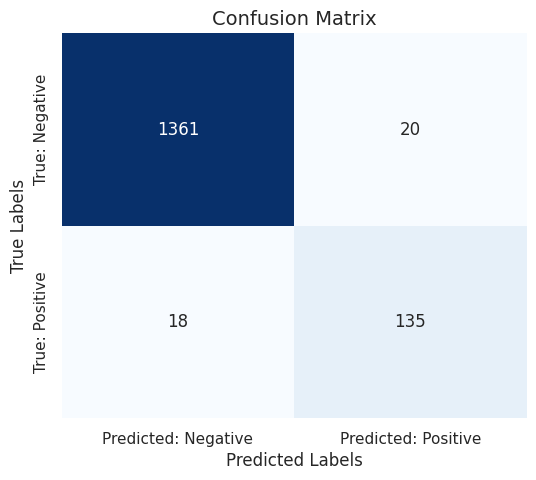

In [263]:
conf_matrix = confusion_matrix(y_val, y_val_pred) # Generate confusion matrix
# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Negative', 'Predicted: Positive'],
            yticklabels=['True: Negative', 'True: Positive'])

# Customize the plot
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Validation Set Confusion Matrix', fontsize=14)
plt.show()

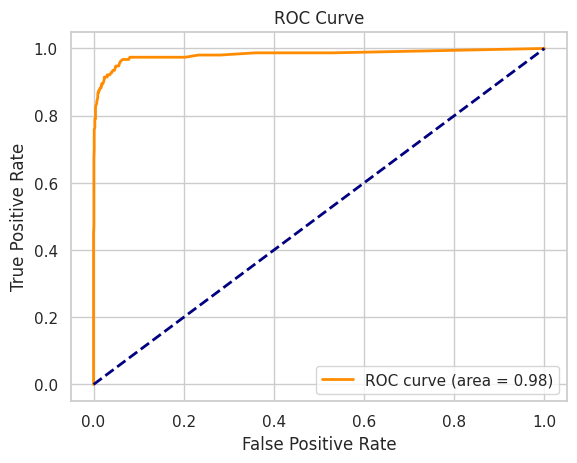

In [264]:
# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [265]:
# Testing the model on the test data
y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

In [266]:
# Test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

In [267]:
print("\nTest Metrics (Without Hyperparameter Tuning):")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"ROC AUC: {test_roc_auc:.2f}")

# Classification report for test data
print("\nClassification Report (Test - Without Hyperparameter Tuning):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(test_conf_matrix)


Test Metrics (Without Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.88
Recall: 0.88
F1 Score: 0.88
ROC AUC: 0.99

Classification Report (Test - Without Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.88      0.88      0.88       154

    accuracy                           0.98      1535
   macro avg       0.93      0.93      0.93      1535
weighted avg       0.98      0.98      0.98      1535


Confusion Matrix:
[[1363   18]
 [  19  135]]


**Plotting the Confusion Matrix for Test data without hyperparameter tuning**

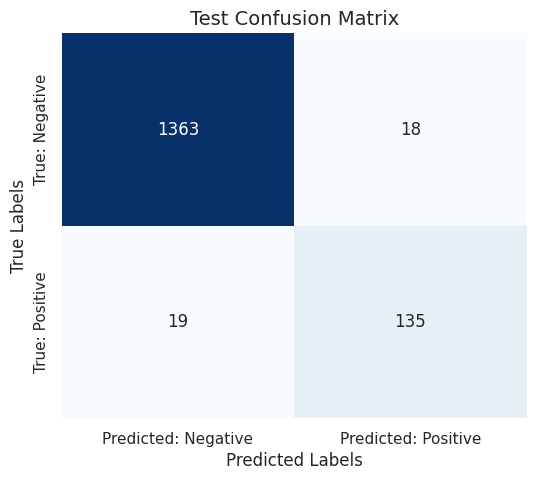

In [268]:
test_conf_matrix = confusion_matrix(y_test, y_test_pred) # Generate confusion matrix
# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Negative', 'Predicted: Positive'],
            yticklabels=['True: Negative', 'True: Positive'])

# Customize the plot
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Test Data Confusion Matrix', fontsize=14)
plt.show()

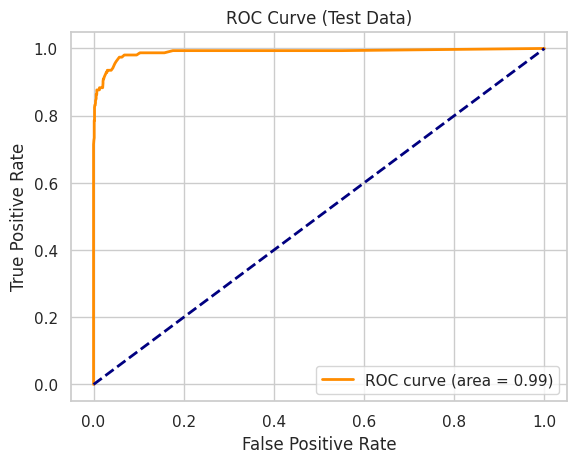

In [269]:
# Plotting the ROC curve
test_roc_auc = roc_auc_score(y_test, y_test_prob)
# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Reference diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Data)')
plt.legend(loc="lower right")
plt.show()

# Hyperparameter Tuning with RandomizedSearchCV

In [270]:
# Hyperparameter tuning
param_dist = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

In [271]:
# Performing RandomizedSearchCV for best parameters
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1', random_state=42, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)
print("done")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
done


In [272]:
# Best parameters and model
best_params = random_search.best_params_
print("\nBest Parameters:")
print(best_params)

best_model = random_search.best_estimator_
print("done")


Best Parameters:
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20, 'classifier__criterion': 'entropy'}
done


In [273]:
# Evaluating the best model on validation data
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]
print("done")

done


In [274]:
# Validation metrics (After Hyperparameter Tuning)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_prob)
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("done")

done


In [275]:
print("\nValidation Metrics (After RandomSearch Hyperparameter Tuning):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report for validation data
print("\nClassification Report (Validation - After Hyperparameter Tuning):")
print(classification_report(y_val, y_val_pred))


Validation Metrics (After Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
ROC AUC: 0.98

Confusion Matrix:
[[1366   15]
 [  16  137]]

Classification Report (Validation - After Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.90      0.90      0.90       153

    accuracy                           0.98      1534
   macro avg       0.94      0.94      0.94      1534
weighted avg       0.98      0.98      0.98      1534



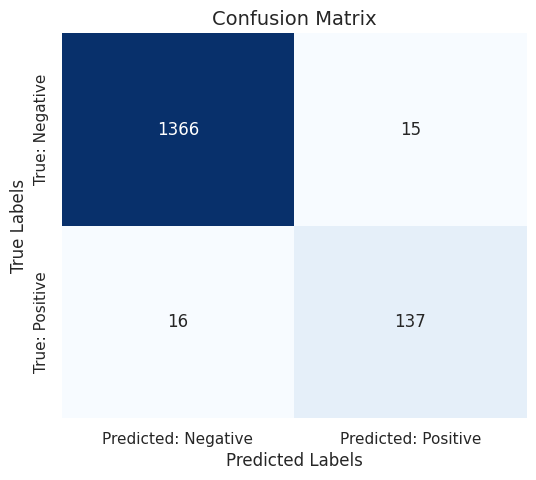

In [276]:
conf_matrix = confusion_matrix(y_val, y_val_pred) # Generate confusion matrix
# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Negative', 'Predicted: Positive'],
            yticklabels=['True: Negative', 'True: Positive'])

# Customize the plot
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('RandomSearch Validation Set Confusion Matrix', fontsize=14)
plt.show()

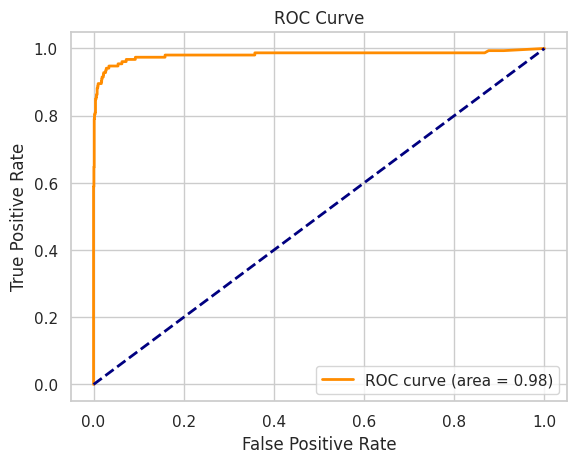

In [277]:
# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomSearch Validation Set ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [278]:
# Testing the model on the test data
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]
print("done")

done


In [279]:
# Test metrics (After Hyperparameter Tuning)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("done")

done


In [280]:
print("\nTest Metrics (After RandomSearchCV Hyperparameter Tuning):")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"ROC AUC: {test_roc_auc:.2f}")
print("\nConfusion Matrix:")
print(test_conf_matrix)
# Classification report for test data
print("\nClassification Report (Test - After Hyperparameter Tuning):")
print(classification_report(y_test, y_test_pred))


Test Metrics (After Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.87
Recall: 0.90
F1 Score: 0.88
ROC AUC: 0.99

Confusion Matrix:
[[1361   20]
 [  16  138]]

Classification Report (Test - After Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.87      0.90      0.88       154

    accuracy                           0.98      1535
   macro avg       0.93      0.94      0.94      1535
weighted avg       0.98      0.98      0.98      1535



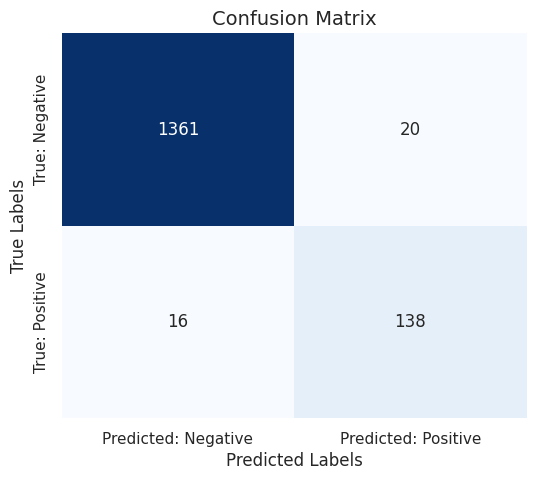

In [281]:
test_conf_matrix = confusion_matrix(y_test, y_test_pred) # Generate confusion matrix
# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Negative', 'Predicted: Positive'],
            yticklabels=['True: Negative', 'True: Positive'])

# Customize the plot
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('RandomSearchCV Test Data Confusion Matrix', fontsize=14)
plt.show()

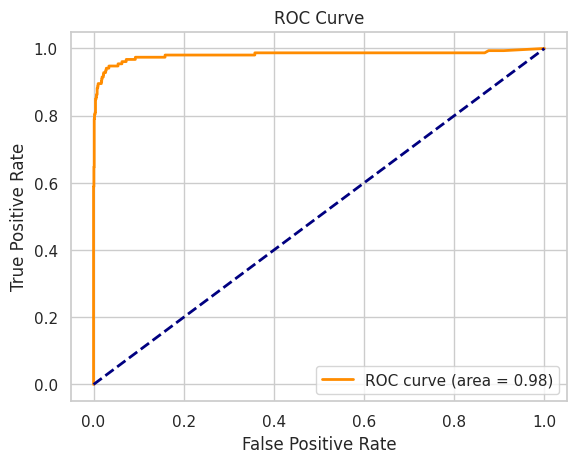

In [282]:
# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomSearchCV Test Data ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Hyperparameter Tuning with GridSearchCV

In [283]:
# Define your parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

In [284]:
# Performing GridSearchCV for best parameters
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)
print("done")  # Grid search is done

Fitting 3 folds for each of 216 candidates, totalling 648 fits
done


In [285]:
# Best parameters and model
best_params = grid_search.best_params_
print("\nBest Parameters:")
print(best_params)

best_model = grid_search.best_estimator_
print("done")


Best Parameters:
{'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
done


**Random Forest Classifier Feature Importance**

In [ ]:
# Extract the trained RandomForestClassifier
rf_classifier = best_model.named_steps['classifier']

# Get feature importance
feature_importances = rf_classifier.feature_importances_

# Pair feature names with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)

In [ ]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from RandomForestClassifier')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

In [286]:
# Evaluate the best model on validation data
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

# Validation metrics (After Hyperparameter Tuning)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_prob)
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("done")

done


In [287]:
print("\nValidation Metrics (After GridSearch Hyperparameter Tuning):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report for validation data
print("\nClassification Report (Validation - After Hyperparameter Tuning):")
print(classification_report(y_val, y_val_pred))


Validation Metrics (After Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.90
Recall: 0.88
F1 Score: 0.89
ROC AUC: 0.98

Confusion Matrix:
[[1366   15]
 [  18  135]]

Classification Report (Validation - After Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.90      0.88      0.89       153

    accuracy                           0.98      1534
   macro avg       0.94      0.94      0.94      1534
weighted avg       0.98      0.98      0.98      1534



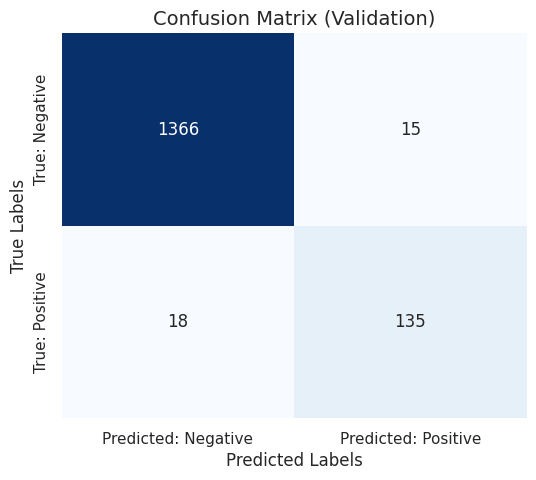

In [288]:
# Generate confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Negative', 'Predicted: Positive'],
            yticklabels=['True: Negative', 'True: Positive'])

# Customize the plot
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('GridSearchCV Confusion Matrix (Validation)', fontsize=14)
plt.show()

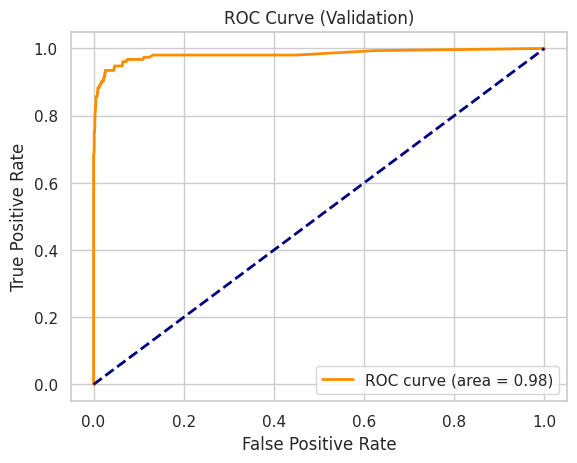

In [289]:
# Plotting the ROC curve for validation data
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GridSearchCV ROC Curve (Validation)')
plt.legend(loc="lower right")
plt.show()

In [290]:
# Testing the model on the test data
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Test metrics (After Hyperparameter Tuning)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("done")

done


In [291]:
print("\nTest Metrics (After GridSearch Hyperparameter Tuning):")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"ROC AUC: {test_roc_auc:.2f}")
print("\nConfusion Matrix:")
print(test_conf_matrix)

# Classification report for test data
print("\nClassification Report (Test - After Hyperparameter Tuning):")
print(classification_report(y_test, y_test_pred))


Test Metrics (After Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.91
Recall: 0.88
F1 Score: 0.89
ROC AUC: 0.99

Confusion Matrix:
[[1368   13]
 [  19  135]]

Classification Report (Test - After Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.91      0.88      0.89       154

    accuracy                           0.98      1535
   macro avg       0.95      0.93      0.94      1535
weighted avg       0.98      0.98      0.98      1535



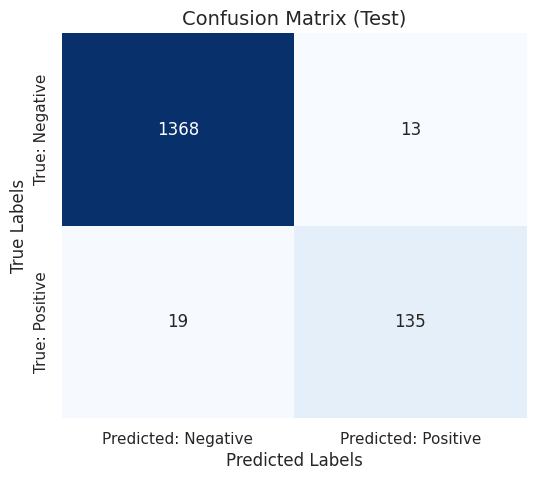

In [292]:
# Generate confusion matrix for test data
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Negative', 'Predicted: Positive'],
            yticklabels=['True: Negative', 'True: Positive'])

# Customize the plot
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('GridSearchCV Confusion Matrix (Test)', fontsize=14)
plt.show()

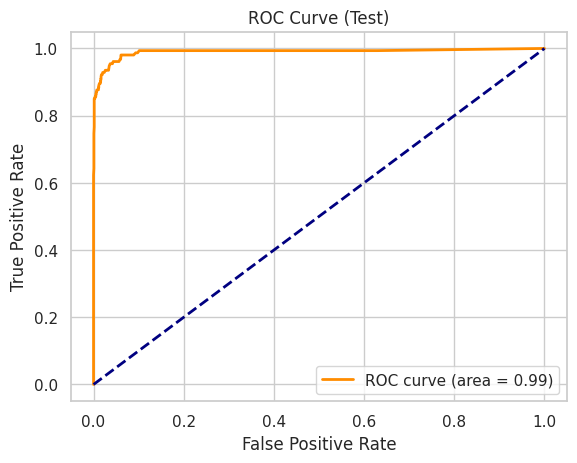

In [293]:
# Plotting the ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GridSearchCV ROC Curve (Test)')
plt.legend(loc="lower right")
plt.show()

In [294]:
# Saving the model
import joblib
joblib.dump(best_model, 'industrial_equipment_fault_detection_best_model.pkl')
print("Model saved successfully!")

Model saved successfully!


# Model Analysis and Conclusion

For industrial equipment fault detection modeling, selecting the best classification metric depends on the specific nature of the problem and the consequences of false positives and false negatives. However, here are some commonly used classification metrics:

1. Precision
Use case: When false positives (incorrectly predicting a fault when there is none) have high consequences (e.g., unnecessary maintenance or shutdowns).

2. Recall (Sensitivity or True Positive Rate)
Use case: When false negatives (failing to detect a fault when it occurs) are more critical (e.g., undetected faults leading to equipment failure or catastrophic events).

3. F1-Score
Use case: When you need to balance precision and recall, especially if both false positives and false negatives are important to minimize.

4. Area Under the Receiver Operating Characteristic Curve (AUC-ROC)
Use case: For models with imbalanced classes, as it evaluates the ability of the classifier to discriminate between the two classes (fault vs. no fault).
Interpretation: A higher AUC indicates a better performing model, where the model is good at distinguishing between faults and normal states.

5. Confusion Matrix
Use case: Provides a comprehensive summary of model performance with respect to true positives, true negatives, false positives, and false negatives. This helps in understanding how many faults are correctly identified, how many non-faults are missed, and so on.

6. Classification Report: provide detailed insights into the performance of a classification model:
- Support: The number of actual occurrences of each class in the dataset.It indicates how many instances of each class exist in the data. Support is useful for understanding the class distribution and can highlight potential class imbalance issues.
- Macro Average (Macro avg): The unweighted mean of the metric (e.g., precision, recall, or F1-score) computed across all classes.
Each class contributes equally to the average, regardless of its support. It is useful for evaluating the model's performance across all classes equally, without being biased by class imbalance.
- Weighted Average (Weighted avg): The average of the metric (e.g., precision, recall, or F1-score) across all classes, weighted by the support of each class. It takes class imbalance into account by giving more weight to classes with higher support. It provides a more realistic measure of overall performance when the dataset is imbalanced. It is useful when you want a single metric that reflects the overall performance on the dataset, considering class distribution.

# Classification Metrics Recommendations

For Fault Detection (with Imbalanced Data): - Typically, Recall (Sensitivity) or F1-Score are ideal metrics because it's crucial not to miss any faults (false negatives). This is the Metric to emphasize on the most in this case.
- For Minimizing False Alarms (False Positives): Precision would be a better choice if false positives lead to high operational costs, like unnecessary maintenance or downtimes.
- For a Balanced Approach: F1-Score balances recall and precision, making it a solid choice for many fault detection problems.
- For General Classification: If the data is balanced and you want an overall measure of model performance, AUC-ROC is a good choice (not suitable for this scenario).

# Uses for this Model:

- Preventive Maintenance Enhancement: Provide predictions that enable industries to shift from scheduled maintenance to a more proactive, condition-based approach.
- Operational Efficiency: Reduce equipment downtime by identifying potential faults early, preventing unexpected breakdowns.
- Optimization of Resource Allocation: Assist industries in efficiently allocating maintenance resources based on the model's predictions.
- Industrial Reliability: Contribute to the development of robust fault detection systems to enhance the overall reliability and efficiency of industrial systems.

# CONCLUSION

The Industrial Equipment Fault Detection project successfully developed a machine learning model using the Random Forest Classifier to classify equipment faults based on environmental and operational parameters. The model achieved high performance metrics, including accuracy, precision, recall, and F1-score, along with a strong ROC-AUC score, demonstrating its reliability in distinguishing faulty from non-faulty equipment. Key features like temperature, vibration, and pressure were identified as critical predictors, offering actionable insights for prioritizing monitoring efforts in predictive maintenance. Through GridSearchCV, optimal hyperparameters were identified, enhancing the model's accuracy and stability. The Random Forest model's flexibility in handling complex, non-linear data makes it well-suited for industrial environments. It can be integrated into real-time systems to enable proactive maintenance, reducing downtime and costs. Future work may involve exploring other algorithms to compare performance and refine fault detection systems further.